# 使用Prophet进行时间序列预测：为优化模型创建输入

## 介绍

从传统的基于化石燃料的能源资源过渡到可再生能源的需求已经加速了太阳能和风能生产的采用。然而，太阳并不总是照耀，风也不总是吹动。客户需要能源的时间可能与太阳能和风能潜力高的时间不一致，这是可再生能源的一个关键挑战。电池可以作为这个问题的解决方案，使储存的能源可以在一天中任何时候通过放电使用。

在这个例子中，我们将利用太阳能和电池来满足运营大学建筑和相关课程的能源需求。在接下来的部分中，我们将描述问题陈述，并演示如何使用数据科学和数学优化来最优地解决给定的问题。

本例中使用的信息来自于[IEEE的预测+优化技术挑战](https://ieee-dataport.org/competitions/ieee-cis-technical-challenge-predictoptimize-renewable-energy-scheduling)。

## 目标和先决条件

在这个例子中，我们考虑澳大利亚墨尔本校园中的一座大学建筑，该建筑在六天内（周一至周六）安排了一系列课程。

建筑和每门课程都有一定的能源需求需要满足。建筑的能源需求被假定为已知，而每门课程基于所需资源（如班级规模或实验室）有不同的需求。该建筑安装了两块太阳能板，能够提供能源，并且还可以直接从电网购买电力以满足需求。此外，该建筑配备了两个电池，可以存储太阳能电池板提供的能源，并在需要时提供这些能源。

本项目的关键学习部分是将时间序列数据预测与数学优化结合起来。与本库中的其他示例不同，这里我们将太阳能预测的预测范围纳入其中，这将作为优化问题的主要输入。

这个例子适合数学优化的初学者。它假设你对数据处理和数据驱动建模有一定的了解，以及对Python和使用Gurobi Python API有基本了解。

该问题需要安装以下Python包：

- **pandas**：用于数据分析和操作 
- **numpy**：用于数学计算
- **matplotlib**：用于绘图和可视化信息
- **prophet**：用于预测未来太阳能输出

## 问题陈述

给定即将到来的一周的课程安排和有关太阳能潜力的历史数据，目标是确定最佳的电池充放电计划，以满足举办课程的建筑的能源需求。总能源需求由建筑本身的需求加上每门课程所需的能源组成。本例将关注两个目标：
- 最小化未来一周从电网购买的总电力
- 由于电价波动，最小化从电网购买的总电力成本

同时，电池有有限的容量以及在一段时间内充电或放电的限制。这些因素对问题施加了约束，使其难以解决。此外，虽然太阳能电池板可以直接提供电力满足需求，但*每个电池板只能给一个电池充电*。

为简化起见，每天考虑的时间将限制在早上5点到晚上8点之间。如果您可以访问完整的Gurobi许可证（例如通过我们的[学术计划](https://www.gurobi.com/academia/academic-program-and-licenses/)），请随时扩展此问题，解决更大版本的问题。

以下是一周课程安排的视图：

<img src="ClassSchedule.png" width="800" align="left"/>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

<h2> 解决方案方法 </h2>

解决方案方法包括两个组成部分：1) **太阳能可用性的预测组件** 和 2) **确定电池计划以及从电网购买的电量的优化组件**。

首先，我们将利用靠近大学校园区域的太阳能潜力的历史信息，以15分钟为间隔预测下周的太阳能输出。根据这些信息，以及大学建筑的需求和建筑内每门课程的能源需求，我们将使用gurobipy制定并解决一个混合整数规划(MIP)问题，为上述每个目标找到最优解。

### 太阳能预测

我们的解决方案方法首先安装和加载必要的包：

In [ ]:
%pip install Prophet
%pip install gurobipy

In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num
from prophet import Prophet
from prophet.diagnostics import cross_validation
from datetime import datetime
from gurobipy import Model, GRB, quicksum

d:\ComputerSoftware\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


计划举行课程的建筑物上安装了两块太阳能电池板，其发电量加载在两个数据框中：

In [4]:
solarData = pd.read_csv(r'SolarPanel.csv')
solarData.start_timestamp = pd.to_datetime(solarData.start_timestamp)
# 将时间调整为墨尔本当地时间
solarData['start_timestamp'] += pd.to_timedelta(10, unit='h')

C:\Users\Jianhui Zhu\AppData\Local\Temp\ipykernel_15572\2160261983.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  solarData.start_timestamp = pd.to_datetime(solarData.start_timestamp)


请注意，太阳能发电数据以15分钟为间隔报告。此外，我们拥有数据的最后日期是9月30日。数据集的可视化显示在以下图表中：

Text(0, 0.5, 'Solar power generation (kW)')

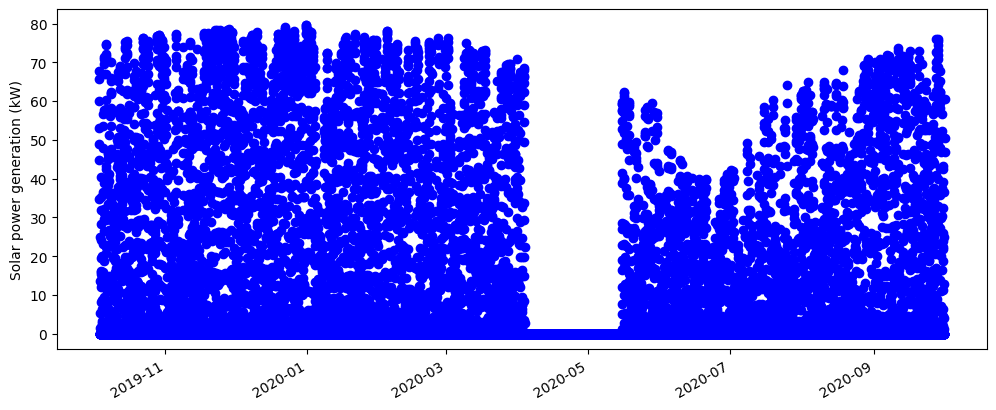

In [ ]:
plt.figure(figsize=(12,5))
plt.scatter(solarData.start_timestamp, solarData.series_values, c='blue')
plt.gcf().autofmt_xdate() # 自动格式化x轴的日期标签，确保日期标签不会重叠
plt.ylabel('Solar power generation (kW)')

上述可视化给出了每个面板的太阳能发电范围和整体趋势的感觉，但很难看到在我们将构建预测和优化解决方案的15分钟级别上发生了什么。下面的图表显示了连续两天每15分钟间隔的太阳能发电量。更改下面的日期和时间，查看太阳能输出如何变化。

Text(0, 0.5, 'Solar power generation (kW)')

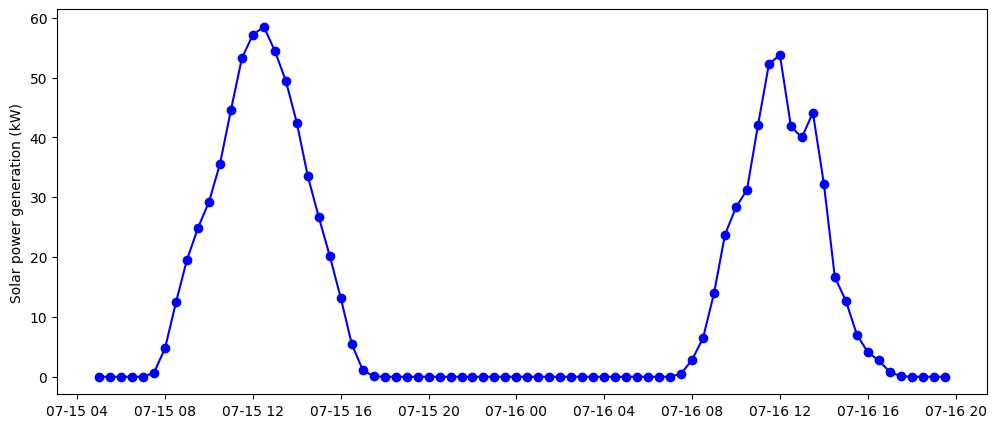

In [11]:
start_date = '2020-07-15 05:00:00'
end_date = '2020-07-16 19:45:00'
plt.figure(figsize=(12,5))
plt.plot(solarData.start_timestamp[(solarData.start_timestamp >= start_date) & (solarData.start_timestamp < end_date)], 
           solarData.series_values[(solarData.start_timestamp >= start_date) & (solarData.start_timestamp < end_date)], '-o', c='blue')
plt.ylabel('Solar power generation (kW)')

回到第一个图表，你可能已经注意到每个太阳能电池板的数据似乎不正确。在第一个面板中，大约一个月期间的发电量是一条对角线，而对于第二个面板，发电量恒定为零。以下图表显示了这种模式以及发生的日期/时间。

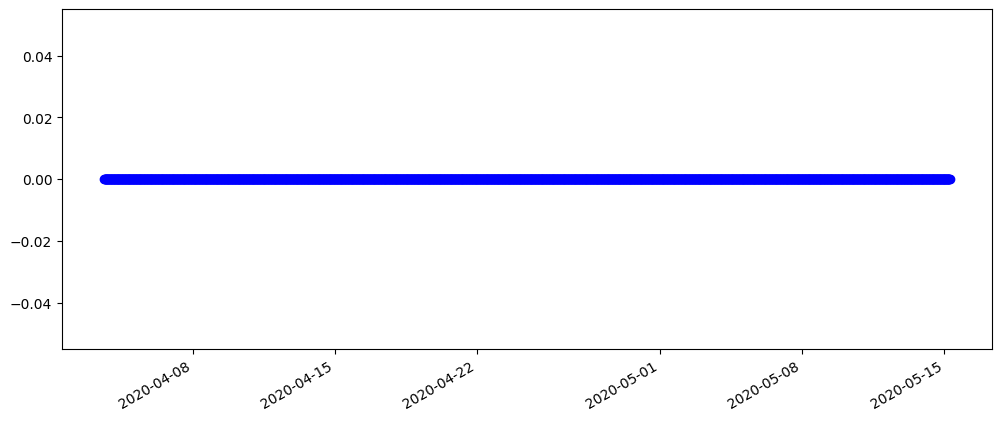

In [12]:
s0 = solarData[(solarData.start_timestamp >= '2020-04-03 15:30:00') & (solarData.start_timestamp < '2020-05-15 07:00:00')]
plt.figure(figsize=(12,5))
plt.scatter(s0.start_timestamp, s0.series_values, c='blue')
plt.gcf().autofmt_xdate()

我们稍后将在示例中移除这些点，因为它们与我们之前看到的一般每日模式不符。

在本例中，我们将利用Facebook的Prophet时间序列预测来预测即将到来的太阳能发电量。Prophet使用方便，并且已经在多种情况下显示出对这类问题的令人满意的性能。

训练数据设置为符合Prophet的格式，然后我们将使用派生的模型来得出下周太阳能输出的预测。最后，我们裁剪预测值，获取2020年10月5日星期一至10月10日星期六这一周期内我们需要的时间。

In [ ]:
solarB = pd.DataFrame()
solarB['ds'] = solarData.start_timestamp
solarB['y'] = solarData.series_values
solarB = solarB.loc[~solarB.index.isin(s0.index)]
modelB = Prophet(changepoints=['2019-11-01','2019-12-01','2020-01-01','2020-02-01','2020-03-01','2020-06-01','2020-07-01','2020-08-01','2020-09-01'])
modelB.add_seasonality(name='daily', period=1, fourier_order=5, prior_scale=10, mode = 'multiplicative')
modelB.fit(solarB)
futureB = modelB.make_future_dataframe(periods=452, freq='30min')
forecastB = modelB.predict(futureB)

15:25:18 - cmdstanpy - INFO - Chain [1] start processing
15:25:21 - cmdstanpy - INFO - Chain [1] done processing


RMSE:10.193452 MAE:5.946682


Text(0, 0.5, 'Solar power generation (kW)')

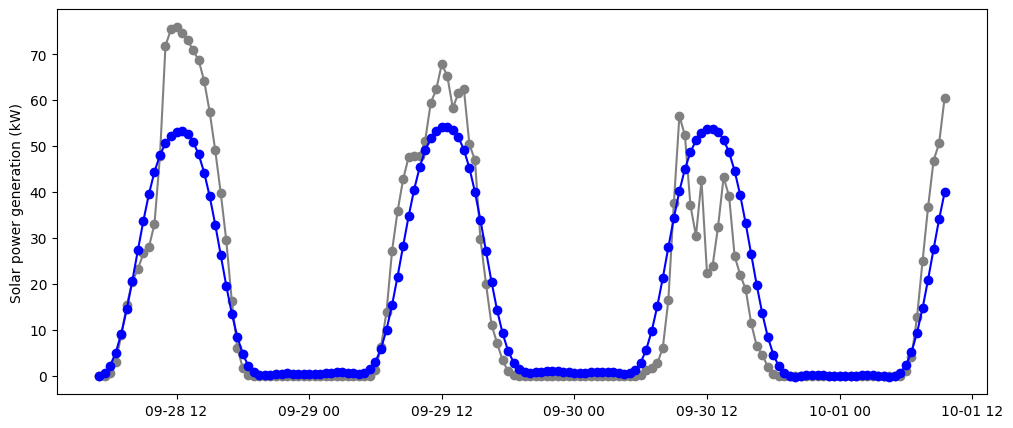

In [15]:
diff = solarB.merge(forecastB[['ds','yhat']])
rmse = np.sqrt(np.mean(np.square(diff.y - diff.yhat)))
mae = np.mean(np.abs(diff.y - diff.yhat))
print(f"RMSE:{round(rmse,6)} MAE:{round(mae,6)}")
plt.figure(figsize=(12,5))
plt.plot(diff.ds[diff.ds >= '2020-09-28 05:00:00'], diff.y[diff.ds >= '2020-09-28 05:00:00'], '-o', c = 'grey')
plt.plot(diff.ds[diff.ds >= '2020-09-28 05:00:00'], diff.yhat[diff.ds >= '2020-09-28 05:00:00'], '-o', c = 'blue')
plt.ylabel('Solar power generation (kW)')

In [ ]:
forecastB_October = forecastB[(forecastB.ds >= '2020-10-05')]
forecastB_October = forecastB_October.set_index('ds')
forecastB_October_Optimization = forecastB_October.copy().between_time('05:00:00','19:30:00')
forecastB_October_Optimization.iloc[forecastB_October_Optimization.yhat < 0,] = 0

# 这是我们将在优化模型中使用的输出文件
forecastB_October_Optimization.to_csv('pred_solar_values.csv', index = False)

版权所有 © 2022 Gurobi Optimization, LLC